In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# DISTRIBUSI DATASET

In [2]:
from datasets import load_dataset
import pandas as pd

def hitung_distribusi_dataset(hf_dataset_name="akunskripsiapillv1/indochart-v2-dataset"):
    # Load seluruh split: train, validation, test
    splits = ["train", "validation", "test"]
    data = {split: load_dataset(hf_dataset_name, split=split) for split in splits}

    # Gabungkan semua split ke dalam satu DataFrame
    df_all = pd.concat(
        [pd.DataFrame(d).assign(split=split) for split, d in data.items()],
        ignore_index=True
    )

    # Hitung distribusi berdasarkan kombinasi source dan chartType
    distribusi = (
        df_all.groupby(["source", "chartType", "split"])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )

    # Hitung total dan persentase
    distribusi["Jumlah"] = distribusi[["train", "validation", "test"]].sum(axis=1)
    distribusi["Persentase"] = (distribusi["Jumlah"] / distribusi["Jumlah"].sum() * 100).round(2)

    # Ganti nama kolom untuk tabel
    distribusi = distribusi.rename(columns={
        "source": "Sumber",
        "chartType": "Tipe Grafik",
        "train": "Train",
        "validation": "Validation",
        "test": "Test"
    })

    return distribusi.sort_values(by=["Sumber", "Tipe Grafik"]).reset_index(drop=True)

In [3]:
distribusi_tipe = hitung_distribusi_dataset()
print(distribusi_tipe)

train.parquet:   0%|          | 0.00/2.19G [00:00<?, ?B/s]

val.parquet:   0%|          | 0.00/274M [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/29423 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3678 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3678 [00:00<?, ? examples/s]

split    Sumber Tipe Grafik  Test  Train  Validation  Jumlah  Persentase
0           bps         bar   240   1920         240    2400        6.53
1           bps      column   360   2880         360    3600        9.79
2           bps       donut   347   2774         347    3468        9.43
3           bps         pie   231   1850         231    2312        6.29
4      statista         bar   827   6618         827    8272       22.49
5      statista      column  1632  13055        1632   16319       44.37
6      statista         pie    41    326          41     408        1.11


In [4]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter

# Download NLTK resources jika belum
nltk.download('punkt', quiet=True)

def calculate_text_statistics(text_list):
    """
    Menghitung statistik linguistik, termasuk TTR dan Text Coverage.

    Parameters:
        text_list (list): List deskripsi grafik.

    Returns:
        dict: Statistik linguistik dan rasio keragaman.
    """
    total_char = 0
    total_token = 0
    total_sentence = 0
    total_ttr = 0
    total_vocab_ratio = 0

    all_tokens = []
    token_lists = []

    # Tokenisasi global untuk seluruh teks
    for text in text_list:
        text = str(text)
        total_char += len(text)

        tokens = word_tokenize(text.lower())
        token_lists.append(tokens)
        total_token += len(tokens)
        all_tokens.extend(tokens)

        sentences = sent_tokenize(text)
        total_sentence += len(sentences)

    # Kosakata keseluruhan korpus
    vocab = set(all_tokens)
    vocab_size = len(vocab)

    # Hitung TTR dan rasio cakupan vocab untuk setiap deskripsi
    for tokens in token_lists:
        if len(tokens) > 0:
            uniq_tokens = set(tokens)
            
            # Hitung TTR
            ttr = len(uniq_tokens) / len(tokens)

            # Hitung VOR
            vocab_ratio = len(uniq_tokens.intersection(vocab)) / vocab_size
            
            total_ttr += ttr
            total_vocab_ratio += vocab_ratio
            
    num_texts = len(text_list)

    return {
        "#Vocab": vocab_size,
        "Avg. Char": round(total_char / num_texts, 2),
        "Avg. Token": round(total_token / num_texts, 2),
        "Avg. Sentence": round(total_sentence / num_texts, 2),
        "Avg. TTR (Unique/Token)": round(total_ttr / num_texts, 4),
        "Avg. VOR (Unique/Vocab)": round(total_vocab_ratio / num_texts, 4)
    }

In [5]:
from datasets import load_dataset
dataset = load_dataset('akunskripsiapillv1/indochart-v2-dataset')
    
all_data = pd.concat([
    pd.DataFrame({'description': dataset['train']['label'], 'source': dataset['train']['source']}),
    pd.DataFrame({'description': dataset['validation']['label'], 'source': dataset['validation']['source']}),
    pd.DataFrame({'description': dataset['test']['label'], 'source': dataset['test']['source']})
])

# Hitung statistik per sumber data
print("=== ANALISIS PER SUMBER DATA ===")
for source in ['statista', 'bps']:
    source_descriptions = all_data[all_data['source'] == source]['description'].tolist()
    print(f"\n📊 Sumber: {source.upper()}")
    stats = calculate_text_statistics(source_descriptions)
    for key, value in stats.items():
        print(f"{key}: {value}")

# Hitung statistik gabungan (IndoChart)
print("\n📊 GABUNGAN (IndoChart):")
all_descriptions = all_data['description'].tolist()
stats_all = calculate_text_statistics(all_descriptions)
for key, value in stats_all.items():
    print(f"{key}: {value}")

=== ANALISIS PER SUMBER DATA ===

📊 Sumber: STATISTA
#Vocab: 30849
Avg. Char: 298.65
Avg. Token: 47.04
Avg. Sentence: 2.52
Avg. TTR (Unique/Token): 0.7702
Avg. VOR (Unique/Vocab): 0.0011

📊 Sumber: BPS
#Vocab: 4231
Avg. Char: 462.75
Avg. Token: 76.33
Avg. Sentence: 2.01
Avg. TTR (Unique/Token): 0.531
Avg. VOR (Unique/Vocab): 0.0096

📊 GABUNGAN (IndoChart):
#Vocab: 33236
Avg. Char: 351.21
Avg. Token: 56.42
Avg. Sentence: 2.36
Avg. TTR (Unique/Token): 0.6936
Avg. VOR (Unique/Vocab): 0.0011


## Resolusi Gambar

In [6]:
from datasets import load_dataset
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load semua data
splits = ["train", "validation", "test"]
all_data = []

for split in splits:
    ds = load_dataset("akunskripsiapillv1/indochart-v2-dataset", split=split)
    for item in ds:
        img = Image.open(BytesIO(item['image']))
        width, height = img.size
        source = item["source"]
        aspect_ratio = width / height
        all_data.append({
            "width": width,
            "height": height,
            "aspect_ratio": aspect_ratio,
            "source": source,
        })

df = pd.DataFrame(all_data)

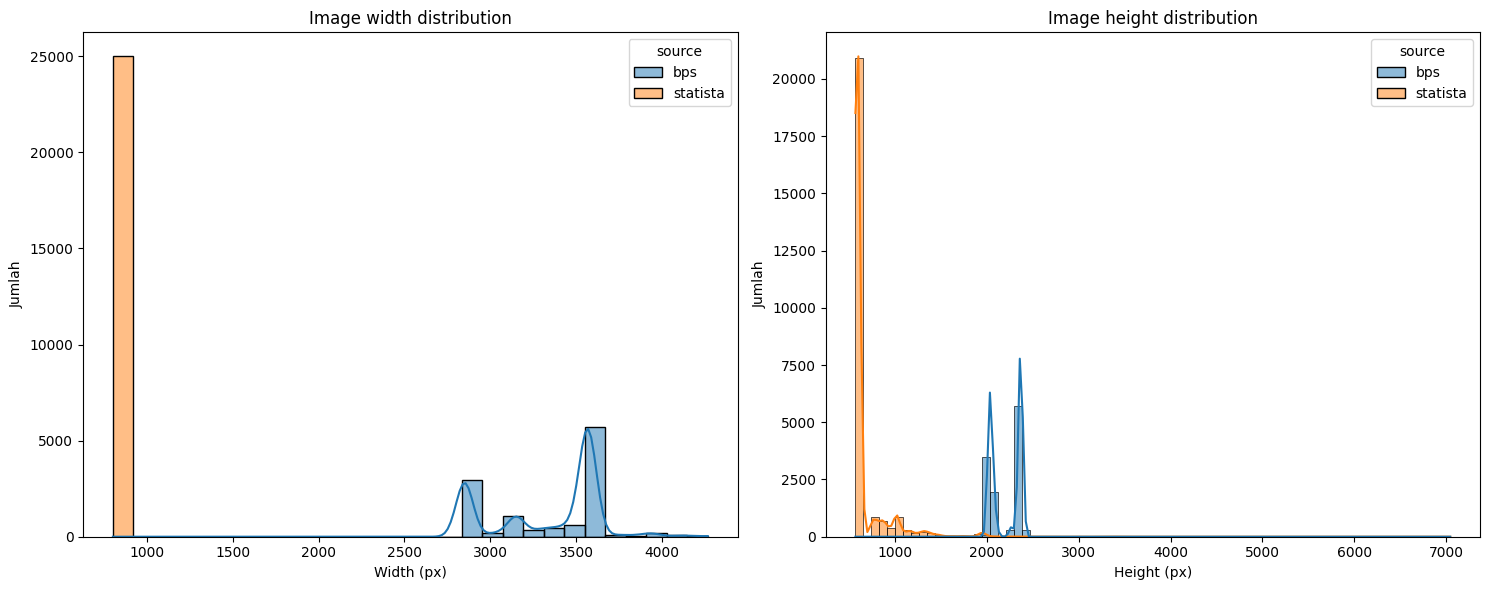

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=df, x="width", hue="source", ax=ax[0], kde=True)
ax[0].set_title("Image width distribution")
ax[0].set_xlabel("Width (px)")
ax[0].set_ylabel("Jumlah")

sns.histplot(data=df, x="height", hue="source", ax=ax[1], kde=True)
ax[1].set_title("Image height distribution")
ax[1].set_xlabel("Height (px)")
ax[1].set_ylabel("Jumlah")

plt.tight_layout()
plt.savefig("imgres_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

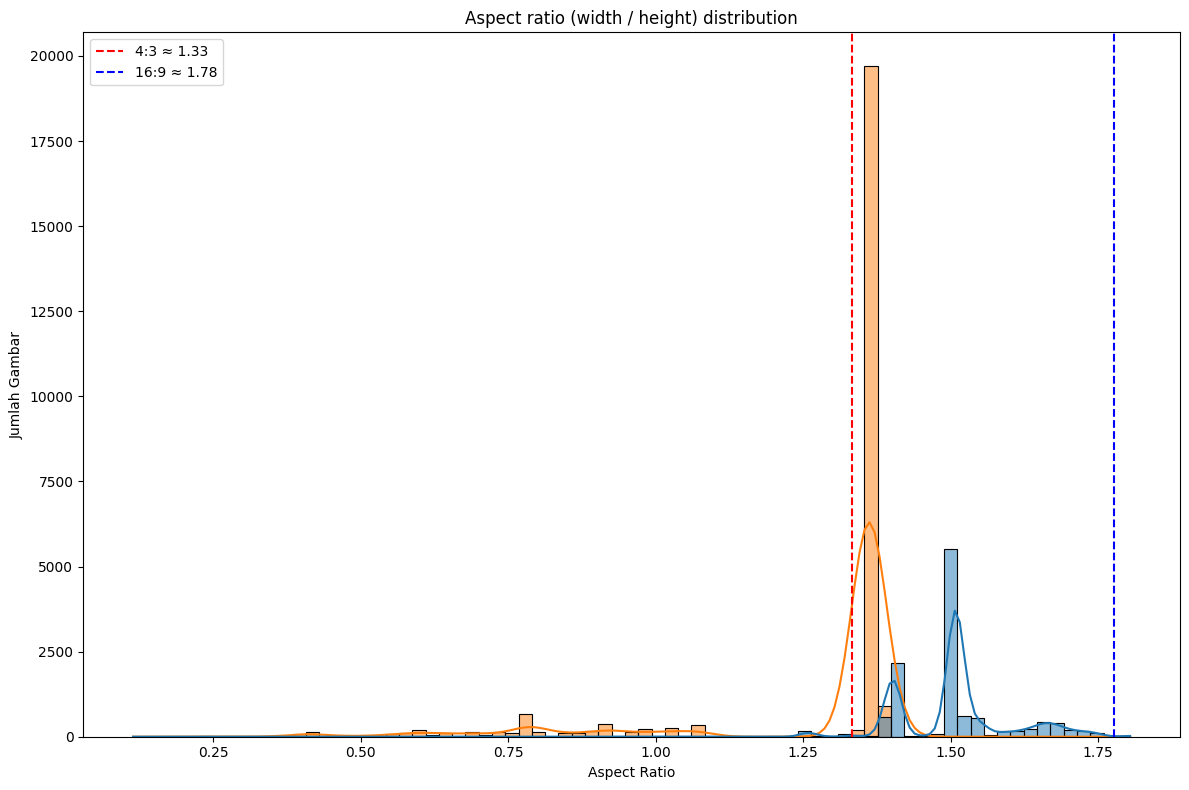

In [8]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x="aspect_ratio", hue="source", bins=75, kde=True)

# Tambahkan garis referensi aspek rasio umum
plt.axvline(4/3, color="red", linestyle="--", label="4:3 ≈ 1.33")
plt.axvline(16/9, color="blue", linestyle="--", label="16:9 ≈ 1.78")

plt.title("Aspect ratio (width / height) distribution")
plt.xlabel("Aspect Ratio")
plt.ylabel("Jumlah Gambar")
plt.legend()
plt.tight_layout()
plt.savefig("aspect_ratio_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

## Token Frequency Distribution

In [9]:
!pip install -q sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.8 MB/s eta 0:00:00


In [10]:
from datasets import load_dataset, concatenate_datasets
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
import matplotlib.pyplot as plt
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# 1. Load dataset semua split dan gabungkan
splits = ["train", "validation", "test"]
all_splits = [load_dataset("akunskripsiapillv1/indochart-v2-dataset", split=split) for split in splits]
full_dataset = concatenate_datasets(all_splits)

# 2. Ambil stopwords Bahasa Indonesia
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

# 3. Filter berdasarkan sumber dan ambil 'label' yang tidak kosong
statista_corpus = [item["label"] for item in full_dataset 
                   if item["source"] == "statista" and item["label"].strip() != ""]

bps_corpus = [item["label"] for item in full_dataset 
              if item["source"] == "bps" and item["label"].strip() != ""]

# 4. Vectorizer (gunakan stopwords dan batas fitur)
vectorizer = CountVectorizer(stop_words=stopwords, max_features=50)

# Transformasi dan dapatkan fitur
docs_statista = vectorizer.fit_transform(statista_corpus)
features_statista = vectorizer.get_feature_names_out()

docs_bps = vectorizer.fit_transform(bps_corpus)
features_bps = vectorizer.get_feature_names_out()

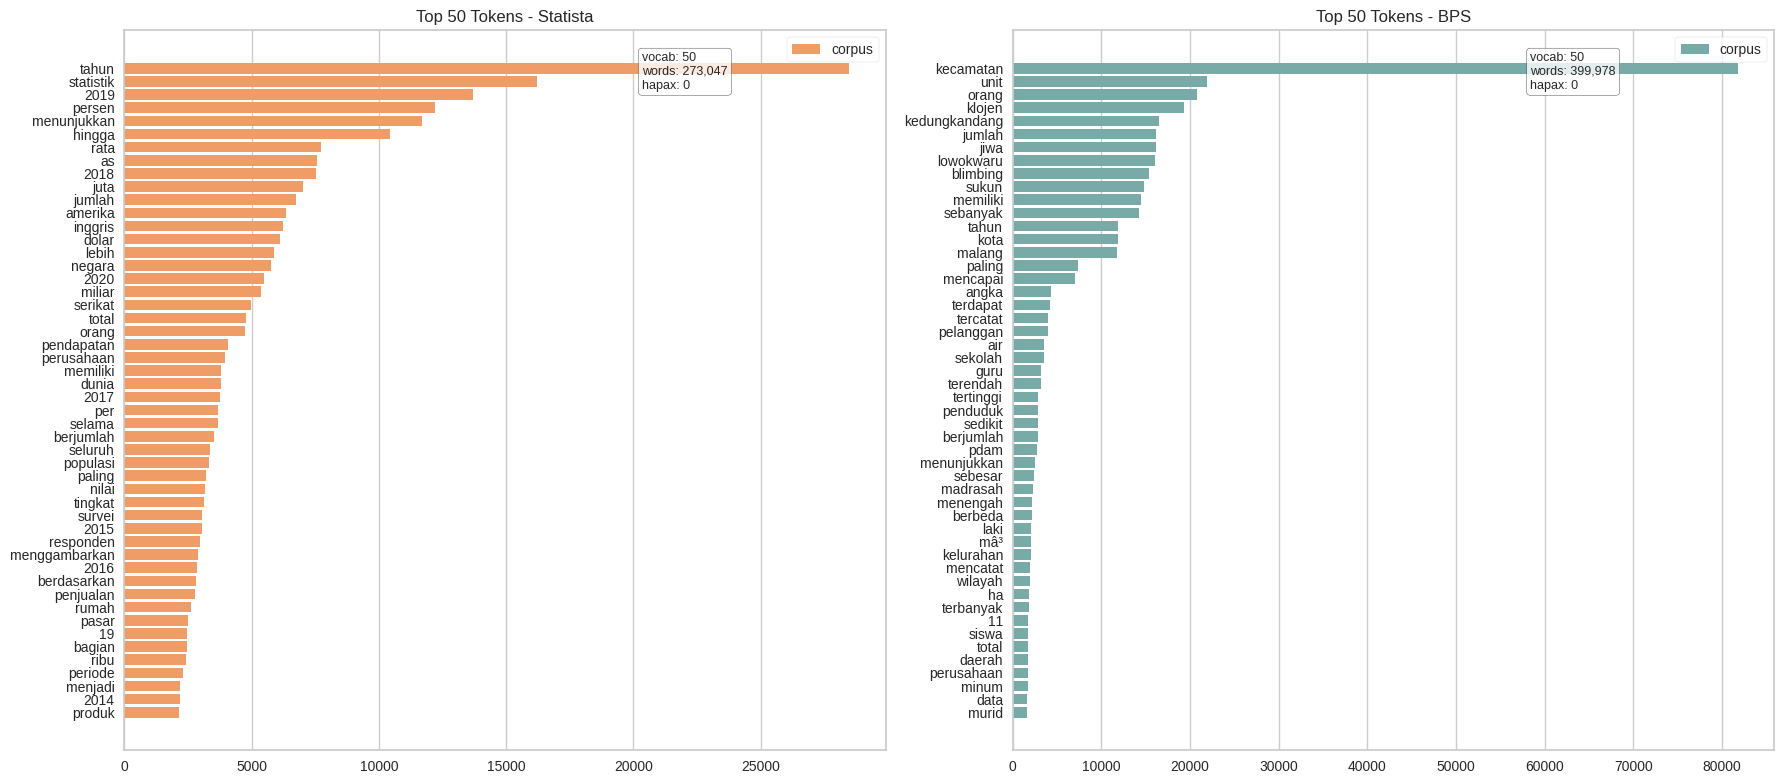

In [11]:
# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Visualisasi Statista
visualizer1 = FreqDistVisualizer(
    features=features_statista,
    orient='h',
    ax=axes[0],
    color="#EF9C66"  # Warna oranye untuk Statista
)
visualizer1.fit(docs_statista)
visualizer1.finalize()
axes[0].set_title("Top 50 Tokens - Statista")

# Visualisasi BPS
visualizer2 = FreqDistVisualizer(
    features=features_bps,
    orient='h',
    ax=axes[1],
    color="#78ABA8"  # Warna teal untuk BPS
)
visualizer2.fit(docs_bps)
visualizer2.finalize()
axes[1].set_title("Top 50 Tokens - BPS")

plt.tight_layout()
plt.savefig("token_freq_dist.png", dpi=300, bbox_inches='tight')
plt.show()